In [52]:
using LinearAlgebra
using Statistics
using Plots
using Random
using Distributions
using CovarianceEstimation
using StatsBase
import Base: angle

### Two Ensembles

We'll generate some large random matrices from two famous ensembles:

- **GOE (Gaussian Orthogonal Ensemble)**: Real, symmetric matrices.
- **GUE (Gaussian Unitary Ensemble)**: Complex, Hermitian matrices.

1. **GOE (Real Symmetric)**  
   - Off-diagonal entries are normal random variables with variance \(1/n\).  
   - Diagonal entries have variance \(2/n\).  
   - Ensures a real symmetric matrix whose eigenvalues lie near \([-2,2]\).

2. **GUE (Complex Hermitian)**  
   - Off-diagonal entries are complex with real and imaginary parts each having variance \(1/(2n)\).  
   - Diagonal entries are purely real with variance \(1/n\).  
   - Ensures a Hermitian matrix whose eigenvalues also lie near \([-2,2]\).

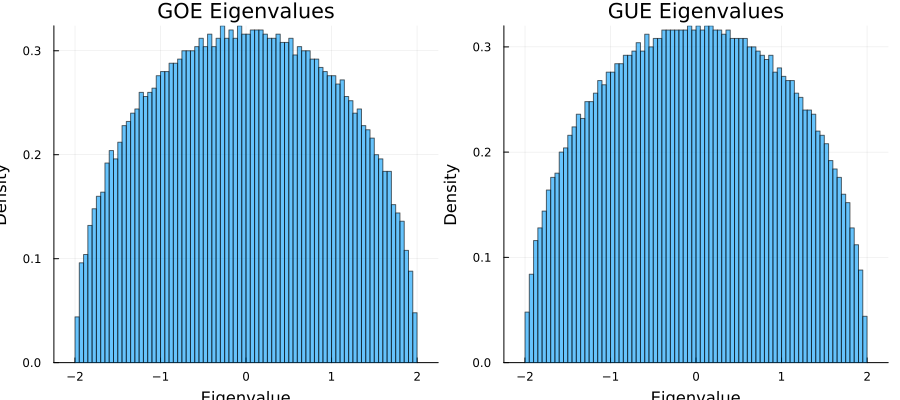

In [62]:
function generate_goe(n::Int)
    M = zeros(Float64, n, n)
    # Fill off-diagonals (i < j)
    for i in 1:n
        for j in i+1:n
            val = randn() / sqrt(n)      # variance = 1/n
            M[i, j] = val
            M[j, i] = val
        end
    end
    # Fill diagonals
    for i in 1:n
        M[i, i] = sqrt(2) * randn() / sqrt(n)  # variance = 2/n
    end
    return M
end


function generate_gue(n::Int)
    A = randn(n, n) + im * randn(n, n)
    # (A + A') / 2 makes it Hermitian; dividing by sqrt n fixes the total variance
    return (A + A') ./ (2 * sqrt(n))
end

n = 5000

goe = generate_goe(n)
gue = generate_gue(n)

eigs_goe = eigvals(goe)
eigs_gue = eigvals(gue)

p1 = histogram(eigs_goe, bins=100, normalize=:pdf, 
    title="GOE Eigenvalues", alpha=0.6,
    label="", xlabel="Eigenvalue", ylabel="Density")

p2 = histogram(eigs_gue, bins=100, normalize=:pdf, 
    title="GUE Eigenvalues", alpha=0.6,
    label="", xlabel="Eigenvalue", ylabel="Density")

plot(p1, p2, layout=(1, 2), size=(900, 400))

### Wigner Semicircle Law

Observe they follow the **Wigner semicircle distribution**. For certain large random matrices, when you look at the histogram of their eigenvalues (when scaled), the distribution converges to a **semicircle** given by the formula:

$$
\rho(x) =
\begin{cases}
  \displaystyle \frac{\sqrt{4 - x^2}}{2\pi}, & \text{if } |x|\le 2,\\[1em]
  0, & \text{otherwise}.
\end{cases}
$$

In other words, most of the eigenvalues lie between \(-2\) and \(+2\), and when plotted as a histogram, they form a shape that exactly matches a semicircle of radius 2. This is quite interesting as from these very random matrices we can create a somewhat deterministic pattern of eigenvalues when $n$ is large.

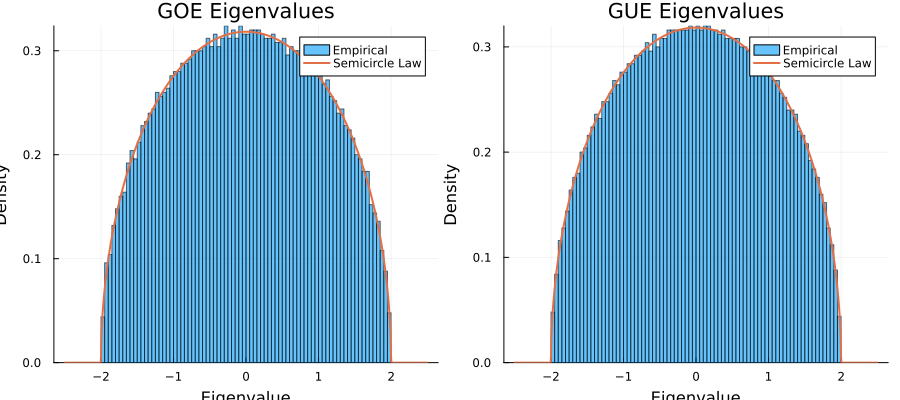

In [64]:
semicirclelaw(x) = abs(x) ≤ 2 ? sqrt(4 - x^2) / (2π) : 0.0

x_vals = range(-2.5, 2.5, length=1000)
y_vals = [semicirclelaw(x) for x in x_vals]

p1 = histogram(eigs_goe, bins=100, normalize=:pdf, alpha=0.6,
    xlabel="Eigenvalue", ylabel="Density", title="GOE Eigenvalues",
    label="Empirical")
plot!(p1, x_vals, y_vals, lw=2, label="Semicircle Law", legend=:topright)

p2 = histogram(eigs_gue, bins=100, normalize=:pdf, alpha=0.6,
    xlabel="Eigenvalue", ylabel="Density", title="GUE Eigenvalues",
    label="Empirical")
plot!(p2, x_vals, y_vals, lw=2, label="Semicircle Law", legend=:topright)

plot(p1, p2, layout=(1, 2), size=(900, 400))

### Tracy-Widom Law

Let's look at the largest Eigenvalue: while in the previous cell we saw that almost all of the eigenvalues follow the semicircle law. If we just look at the behavior of the largest eigenvalue for large random matrices, this eigenvalue tends to be very close to \(2\) and fluctuates around this.

To study these fluctuations, we apply a special scaling:
  
$$
  X_n = (\lambda_{\text{max}} - 2) \, n^{2/3}
$$
  
  Here:
  - $\lambda_{\text{max}}$ is the largest eigenvalue of the matrix.
  - $n$ is the matrix size.
  - The factor $n^{2/3}$ is chosen because the fluctuations around $2$ decrease roughly as $n^{-2/3}$ when the matrix becomes larger.

The Tracy–Widom law helps us understand extreme fluctuations in complex systems proxied through large random matrices.


### Sample Covariance Matrices

- **Data Matrix $X$:**  
  Imagine you have $n$ samples (rows) of $p$ variables (columns). We can represent these data in an $n \times p$ matrix $X$, where each entry is drawn from a standard normal distribution.

- **Sample Covariance Matrix $S$:**  
  The sample covariance matrix is computed as  
  $$
  S = \frac{X^T X}{n},
  $$
  which is a $p \times p$ matrix.

### The Marchenko–Pastur Law

When the dimensions $n$ (number of samples) and $p$ (number of variables) are both large and their ratio  
$$
c = \frac{p}{n}
$$
remains fixed, the eigenvalues of $S$ follow a predictable pattern described by the MP law. This law gives the probability density of eigenvalues $\lambda$ as

$$
\rho_{\text{MP}}(\lambda) = \frac{1}{2\pi c \lambda} \sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)},
$$
for $\lambda$ in the interval $[\lambda_-, \lambda_+]$, where

$$
\lambda_- = (1 - \sqrt{c})^2, \quad \lambda_+ = (1 + \sqrt{c})^2.
$$

Outside this interval, the density is zero.

Here again we see some RMT magic: even though the data is completely random, the eigenvalue distribution of its covariance matrix follows a very specific and predictable law—the Marchenko–Pastur law.


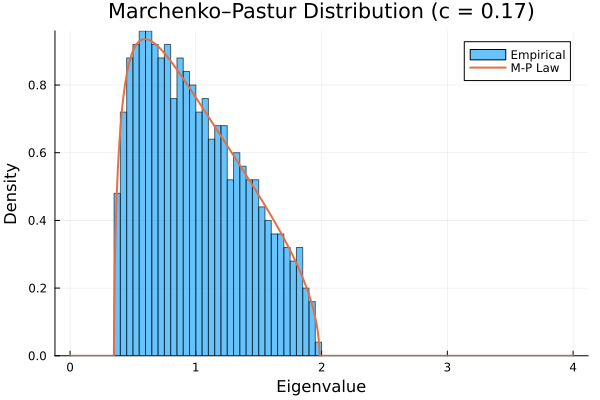

In [78]:
n = 3000
p = 500
c = p / n

X = randn(n, p)
S = (X' * X) / n
eigs_mp = eigvals(S)  

histogram(eigs_mp, bins=50, normalize=:pdf,
          label="Empirical", alpha=0.6,
          xlabel="Eigenvalue", ylabel="Density")

function mp_density(x, c)
    λ_minus = (1 - sqrt(c))^2
    λ_plus = (1 + sqrt(c))^2
    if x < λ_minus || x > λ_plus
        return 0.0
    else
        return sqrt((λ_plus - x) * (x - λ_minus)) / (2π * c * x)
    end
end

x_mp = range(0, 4, length=1000)
y_mp = [mp_density(xi, c) for xi in x_mp]

plot!(x_mp, y_mp, label="M-P Law", lw=2,
      title="Marchenko–Pastur Distribution (c = $(round(c, digits=2)))",
      legend=:topright)

### Curses of Dimensionality
In many applications (e.g., finance, genomics, or machine learning), we need to estimate the covariance matrix of a dataset. A naive approach is to *sample covariance matrix*, but when the number of observations is not very large relative to the number of variables, the sample covariance can be noisy and unstable.

### Ledoit-Wolfe Shrinkage
This technique allows us to improves the estimation by “shrinking” the sample covariance matrix toward a more structured target (often a scaled identity matrix). Note like many other shrinkage operators you may know like James Stien, this creates a biased estimator for tradeoff in estimation variance reduction. The resulting estimator is more robust, particularly in high-dimensional settings.


We use the Ledoit–Wolf shrinkage covariance from the `CovarianceEstimation.jl` package.


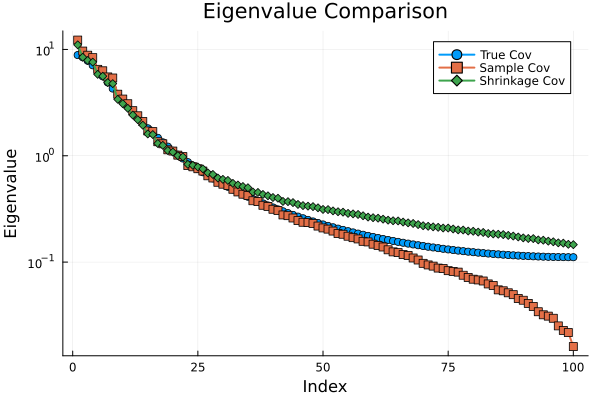

In [107]:
using Random, LinearAlgebra, Statistics, Distributions, CovarianceEstimation, Plots

Random.seed!(123)

n = 200
p = 100

# toeplitz structure
true_cov = [0.8^(abs(i - j)) for i in 1:p, j in 1:p]

dist = MvNormal(zeros(p), true_cov)
X = rand(dist, n)'

sample_cov = cov(X)

S_ledoitwolf = cov(LinearShrinkage(ConstantCorrelation()), X)

mat_true_cov    = Matrix(true_cov)
mat_sample_cov  = Matrix(sample_cov)
mat_shrink_cov  = Matrix(S_ledoitwolf)

p1 = heatmap(mat_true_cov, title="True Covariance", aspect_ratio=1, size=(300,300), colorbar_title="Cov")
p2 = heatmap(mat_sample_cov, title="Sample Covariance", aspect_ratio=1, size=(300,300), colorbar_title="Cov")
p3 = heatmap(mat_shrink_cov, title="Ledoit–Wolf Estimator", aspect_ratio=1, size=(300,300), colorbar_title="Cov")
plot(p1, p2, p3, layout=(1,3), size=(900,300))

eig_true   = sort(eigen(mat_true_cov).values, rev=true)
eig_sample = sort(eigen(mat_sample_cov).values, rev=true)
eig_shrink = sort(eigen(mat_shrink_cov).values, rev=true)

plot(eig_true, label="True Cov", marker=:circle,
     xlabel="Index", ylabel="Eigenvalue",
     title="Eigenvalue Comparison", lw=2,
     yscale=:log10)

plot!(eig_sample, label="Sample Cov", marker=:square, lw=2)
plot!(eig_shrink, label="Shrinkage Cov", marker=:diamond, lw=2)

## Application: High-Dimensional Portfolio

When estimating the covariance matrix of asset returns in a high-dimensional setting (e.g. $ p \gg n $), the sample covariance is super super noisy. This gives us poor portfolio optimization results. One way to improve the estimates is by applying shrinkage (such as the Ledoit–Wolf estimator) which regularizes the covariance estimate.

Consider a minimum variance portfolio allocation problem. From Markowitz's MPT, minimum variance portfolio weights are given by:

$$
w = \frac{\Sigma^{-1} \mathbf{1}}{\mathbf{1}^T \Sigma^{-1} \mathbf{1}},
$$

where $\Sigma$ is the covariance matrix and $\mathbf{1}$ is a vector of ones. We then compute the portfolio risk (i.e. the standard deviation) as

$$
\sigma_p = \sqrt{w^T \Sigma\, w}.
$$

We compare three portfolios:
- **True Minimum Variance:** using the true covariance matrix $\Sigma_{\text{true}}$
- **Sample Covariance Portfolio:** using the sample covariance estimate $S_{\text{sample}}$
- **Ledoit–Wolf Portfolio:** using the shrinkage estimator $S_{\text{lw,cc}}$

We will also compare the “estimated” risk (computed using the estimated covariance) with the “true” risk (computed using \(\Sigma_{\text{true}}\)), and visualize the distribution of portfolio weights.


Estimated vs. True Risk:
Sample Covariance Portfolio:      Estimated risk = 0.0 vs. True risk = 1.45428
Ledoit–Wolf Covariance Portfolio: Estimated risk = 0.05544 vs. True risk = 0.0713
True Minimum Variance Portfolio:  True risk = 0.04401


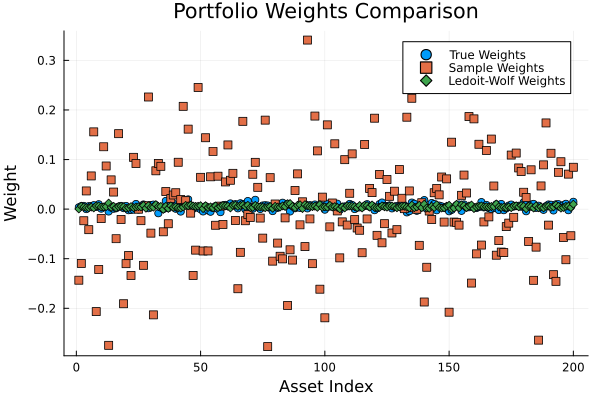

In [128]:
using LinearAlgebra, Statistics, Plots, Random, Distributions

Random.seed!(123)

function min_variance_portfolio(sigma)
    p = size(sigma, 1)
    ones_vec = ones(p)
    inv_sigma = inv(sigma)
    weights = inv_sigma * ones_vec / (ones_vec' * inv_sigma * ones_vec)
    portfolio_var = (weights' * sigma * weights)[1]
    return weights, sqrt(max(portfolio_var, 0))
end

function generate_covariance_data(p, n_samples)
    random_matrix = randn(p, p)
    base_cov = random_matrix * random_matrix' / p
    sigma_true = base_cov + 0.1 * I
    samples = rand(MvNormal(zeros(p), sigma_true), n_samples)'
    S_sample = cov(samples)
    sample_var = diag(S_sample)
    sample_sd = sqrt.(sample_var)
    corr_mat = S_sample ./ (sample_sd * sample_sd')
    avg_corr = (sum(corr_mat) - p) / (p * (p - 1))
    target = avg_corr * (sample_sd * sample_sd')
    for i in 1:p
        target[i, i] = S_sample[i, i]
    end
    shrinkage_intensity = 0.5
    S_lw_cc = (1 - shrinkage_intensity) * S_sample + shrinkage_intensity * target
    return sigma_true, S_sample, S_lw_cc
end

p = 200
n_samples = 50

sigma_true, S_sample, S_lw_cc = generate_covariance_data(p, n_samples)

w_true, risk_true = min_variance_portfolio(sigma_true)
w_sample, risk_sample = min_variance_portfolio(S_sample)
w_lw, risk_lw = min_variance_portfolio(S_lw_cc)

true_risk_sample = sqrt((w_sample' * sigma_true * w_sample)[1])
true_risk_lw = sqrt((w_lw' * sigma_true * w_lw)[1])

println("Estimated vs. True Risk:")
println("Sample Covariance Portfolio:      Estimated risk = ", round(risk_sample, digits=5), " vs. True risk = ", round(true_risk_sample, digits=5))
println("Ledoit–Wolf Covariance Portfolio: Estimated risk = ", round(risk_lw, digits=5), " vs. True risk = ", round(true_risk_lw, digits=5))
println("True Minimum Variance Portfolio:  True risk = ", round(risk_true, digits=5))

histogram(w_sample, bins=20, alpha=0.4, label="Sample Cov", title="Portfolio Weight Distribution", xlabel="Weight", ylabel="Frequency")
histogram!(w_lw, bins=20, alpha=0.4, label="Ledoit–Wolf Cov")
histogram!(w_true, bins=20, alpha=0.4, label="True Cov")

scatter(1:p, w_true, marker=:circle, label="True Weights", xlabel="Asset Index", ylabel="Weight", title="Portfolio Weights Comparison")
scatter!(1:p, w_sample, marker=:square, label="Sample Weights")
scatter!(1:p, w_lw, marker=:diamond, label="Ledoit-Wolf Weights")

In [114]:
using CUDA, LinearAlgebra, Random, Plots
# source @GPT for helping me to fix some GPU and CPU communication issues
function near_identity_unitary_gpu(n, epsilon)
    H_gpu = CUDA.randn(ComplexF64, n, n)
    H_gpu = (H_gpu + H_gpu') / 2
    H_cpu = Array(H_gpu)
    dU_cpu = exp(im * (epsilon * H_cpu))
    return CuArray(dU_cpu)
end

function unitary_brownian_motion_with_eigs_gpu(n, steps, epsilon)
    U = Matrix{ComplexF64}(I, n, n)
    U_gpu = CuArray(U)
    det_path = zeros(ComplexF64, steps+1)
    eig_history = Vector{Vector{ComplexF64}}(undef, steps+1)
    
    U_cpu = Array(U_gpu)
    det_path[1] = det(U_cpu)
    eig_history[1] = sort(eigvals(U_cpu), by=angle)
    
    for i in 1:steps
        dU_gpu = near_identity_unitary_gpu(n, epsilon)
        U_gpu *= dU_gpu
        U_cpu = Array(U_gpu)
        det_path[i+1] = det(U_cpu)
        eig_history[i+1] = sort(eigvals(U_cpu), by=angle)
    end
    return U, det_path, eig_history
end

n = 5         
steps = 1000   
epsilon = 0.1  

final_U, det_path, eig_history = unitary_brownian_motion_with_eigs_gpu(n, steps, epsilon)

θ = range(0, 2π, length=100)

anim = @animate for i in 1:length(eig_history)
    p = plot(aspect_ratio=:equal, xlims=(-1.2, 1.2), ylims=(-1.2, 1.2),
             xlabel="Re", ylabel="Im", title="Eigenvalue Trajectories", legend=false)
    plot!(cos.(θ), sin.(θ), ls=:dash, lw=2, color=:red)
    for j in 1:n
        path = [eig_history[k][j] for k in 1:i]
        plot!(real.(path), imag.(path), lw=2)
    end
    scatter!(real.(eig_history[i]), imag.(eig_history[i]), ms=4, color=:blue)
    p
end

gif(anim, "eigenvalue_paths_gpu.gif", fps=15)


LoadError: InterruptException: